# Porto Seguro’s Safe Driver Prediction

### 此项目为预测汽车保险索赔概率

## 一、查看数据

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.ensemble as se
import sklearn.model_selection as ms
import sklearn.metrics as sm
import xgboost as xgb
import seaborn as sns
import sklearn.preprocessing as sp

In [2]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submission.csv')

In [3]:
print(sample_sub.info())
print(sample_sub.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 2 columns):
id        892816 non-null int64
target    892816 non-null float64
dtypes: float64(1), int64(1)
memory usage: 13.6 MB
None
   id  target
0   0  0.0364
1   1  0.0364
2   2  0.0364
3   3  0.0364
4   4  0.0364
5   5  0.0364
6   6  0.0364
7   8  0.0364
8  10  0.0364
9  11  0.0364


In [4]:
print(train_data.info())
print(train_data.describe())
print(train_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [5]:
print(test_data.info())
print(test_data.describe())
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 58 columns):
id                892816 non-null int64
ps_ind_01         892816 non-null int64
ps_ind_02_cat     892816 non-null int64
ps_ind_03         892816 non-null int64
ps_ind_04_cat     892816 non-null int64
ps_ind_05_cat     892816 non-null int64
ps_ind_06_bin     892816 non-null int64
ps_ind_07_bin     892816 non-null int64
ps_ind_08_bin     892816 non-null int64
ps_ind_09_bin     892816 non-null int64
ps_ind_10_bin     892816 non-null int64
ps_ind_11_bin     892816 non-null int64
ps_ind_12_bin     892816 non-null int64
ps_ind_13_bin     892816 non-null int64
ps_ind_14         892816 non-null int64
ps_ind_15         892816 non-null int64
ps_ind_16_bin     892816 non-null int64
ps_ind_17_bin     892816 non-null int64
ps_ind_18_bin     892816 non-null int64
ps_reg_01         892816 non-null float64
ps_reg_02         892816 non-null float64
ps_reg_03         892816 non-null float64
ps_

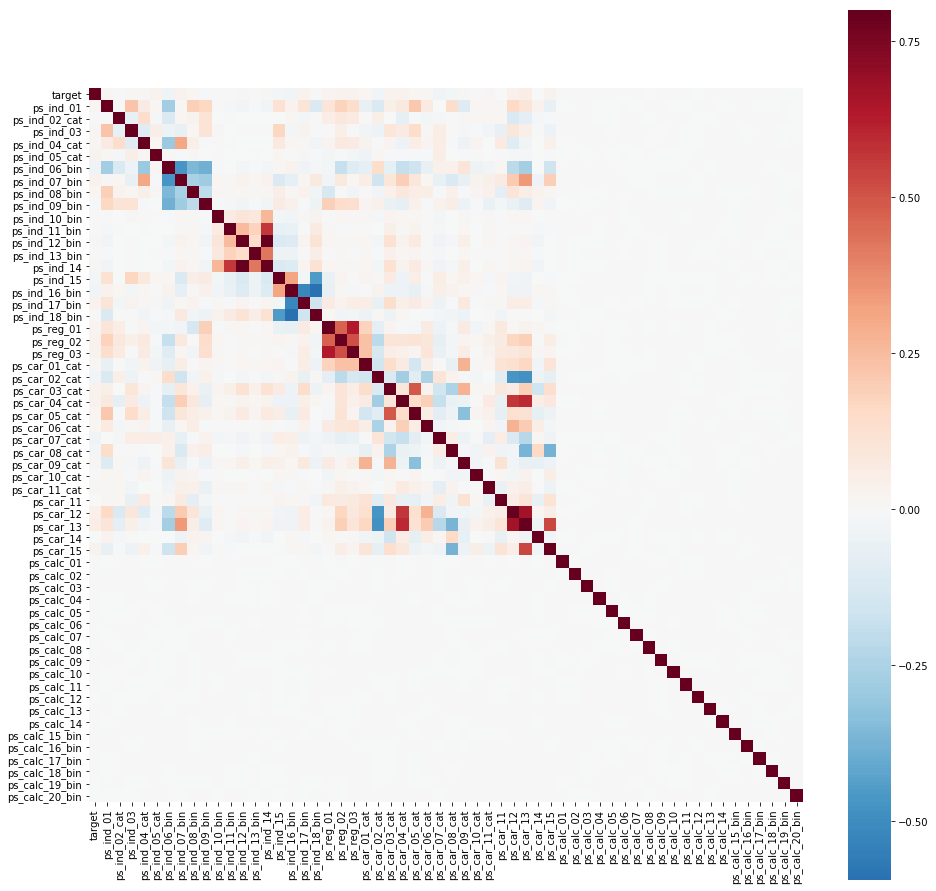

In [6]:
train_data_select = train_data.drop('id',axis=1)
test_data_select = test_data.drop('id',axis=1)
corrmat = train_data_select.corr()
f, ax = plt.subplots(figsize=(16,16))
sns.heatmap(corrmat,vmax=0.8,cmap='RdBu_r',square=True,center=0)

In [7]:
# 从关系图中看出，特征名含ps_calc的数据与其他数据几乎没有关联系，故删除这些特征
calc_columns = []
for c in train_data_select.columns:
    if 'ps_calc' in c:
        calc_columns.append(c)
print('删除的列为：',calc_columns)
train_data_select.drop(calc_columns,axis=1,inplace=True)
test_data_select.drop(calc_columns,axis=1,inplace=True)
print(train_data_select.info())
print(test_data_select.info())

删除的列为： ['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 38 columns):
target           595212 non-null int64
ps_ind_01        595212 non-null int64
ps_ind_02_cat    595212 non-null int64
ps_ind_03        595212 non-null int64
ps_ind_04_cat    595212 non-null int64
ps_ind_05_cat    595212 non-null int64
ps_ind_06_bin    595212 non-null int64
ps_ind_07_bin    595212 non-null int64
ps_ind_08_bin    595212 non-null int64
ps_ind_09_bin    595212 non-null int64
ps_ind_10_bin    595212 non-null int64
ps_ind_11_bin    595212 non-null int64
ps_ind_12_bin    595212 non-null int64
ps_ind_13_bin    595212 non-null int64
ps_ind_14        595212 non-nul

#### 处理含有-1的列

In [8]:
catlist = []
otherlist = []
for column in train_data_select.drop(['target'],axis=1):
    # 类别型特征的缺失数据作为单独类别
    if column[-3:] == 'cat':
        if -1 in train_data_select[column].values:
            train_data_select[column] += 1
            test_data_select[column] += 1
        catlist.append(column)
    # 顺序或连续型特征的缺失值用中位数填充
    elif column[-3:] != 'bin':
        if -1 in train_data_select[column].values:
            train_data_select.loc[train_data_select[column] == -1, column] = train_data_select[column].median()
            test_data_select.loc[test_data_select[column] == -1, column] = test_data_select[column].median()
        otherlist.append(column)
print(catlist)
print(otherlist)

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']
['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']


In [9]:
# 对类别大于2的cat特征进行独热编码
hotlist = []
for column in catlist:
    if train_data_select[column].value_counts().size > 2:
        hotlist.append(column)
        one_hot = pd.get_dummies(train_data_select[column],prefix=column)
        train_data_select = pd.concat([train_data_select.drop([column],axis=1),one_hot],axis=1)
        one_hot = pd.get_dummies(test_data_select[column],prefix=column)
        test_data_select = pd.concat([test_data_select.drop([column],axis=1),one_hot],axis=1)
print(hotlist)
print(train_data_select.info())

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Columns: 207 entries, target to ps_car_11_cat_104
dtypes: float64(8), int64(17), uint8(182)
memory usage: 216.8 MB
None


In [10]:
print(train_data_select.head())

   target  ps_ind_01  ps_ind_03  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  \
0       0          2          5              0              1              0   
1       0          1          7              0              0              1   
2       0          5          9              0              0              1   
3       0          0          2              1              0              0   
4       0          0          0              1              0              0   

   ps_ind_09_bin  ps_ind_10_bin  ps_ind_11_bin  ps_ind_12_bin  \
0              0              0              0              0   
1              0              0              0              0   
2              0              0              0              0   
3              0              0              0              0   
4              0              0              0              0   

         ...          ps_car_11_cat_95  ps_car_11_cat_96  ps_car_11_cat_97  \
0        ...                         0            

In [11]:
# 对顺序性/连续性特征列进行数值缩放，（0,1）间
scaler = sp.MinMaxScaler(feature_range=(0,1))
train_data_select[otherlist] = scaler.fit_transform(train_data_select[otherlist])
test_data_select[otherlist] = scaler.transform(test_data_select[otherlist])
print(train_data_select.describe())
print(test_data_select.describe())

              target      ps_ind_01      ps_ind_03  ps_ind_06_bin  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.036448       0.271483       0.402120       0.393742   
std         0.187401       0.283398       0.245446       0.488579   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.181818       0.000000   
50%         0.000000       0.142857       0.363636       0.000000   
75%         0.000000       0.428571       0.545455       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

       ps_ind_07_bin  ps_ind_08_bin  ps_ind_09_bin  ps_ind_10_bin  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.257033       0.163921       0.185304       0.000373   
std         0.436998       0.370205       0.388544       0.019309   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.0000

# 选择模型训练

In [12]:
# 基尼函数
def gini(truth, predictions):
    g = np.asarray(
        np.c_[truth, predictions, np.arange(len(truth))], dtype=np.float)
    g = g[np.lexsort((g[:, 2], -1 * g[:, 1]))]
    gs = g[:, 0].cumsum().sum() / g[:, 0].sum()
    gs -= (len(truth) + 1) / 2.
    return gs / len(truth)


def gini_xgb(predictions, truth):
    truth = truth.get_label()
    return 'gini', -1.0 * gini(truth, predictions) / gini(truth, truth)

### XGB模型

In [13]:
# 查看模型训练效果
train_x,test_x,train_y,test_y = ms.train_test_split(train_data_select.iloc[:,1:],train_data_select['target'],test_size=0.2,random_state=4)
model = xgb.XGBClassifier(learning_rate=0.05,
                         objective='binary:logistic',
                         silent=0,
                         nthread=4,
                         max_depth=6,
                         subsample=.8,
                         colsample_bytree=.8,
                         n_estimators=200,
                         seed=4,
                         scale_pos_weight=1)
model.fit(train_x,train_y,eval_set=[(train_x,train_y), (test_x,test_y)],eval_metric=gini_xgb,verbose=2)
pred_y = model.predict(test_x)
score = sm.classification_report(test_y,pred_y)
print(score)

[12:02:25] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-error:0.036693	validation_1-error:0.035407	validation_0-gini:-0.222562	validation_1-gini:-0.216647
[12:02:26] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[12:02:27] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-error:0.036701	validation_1-error:0.035332	validation_0-gini:-0.237836	validation_1-gini:-0.23186
[12:02:28] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[12:02:30] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-error:0.036701	va

[12:03:11] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[40]	validation_0-error:0.036708	validation_1-error:0.035323	validation_0-gini:-0.287144	validation_1-gini:-0.252989
[12:03:12] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[12:03:14] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[42]	validation_0-error:0.03671	validation_1-error:0.035323	validation_0-gini:-0.288349	validation_1-gini:-0.253239
[12:03:15] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[12:03:16] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[44]	validation_0-error:0.03671	

[12:03:57] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[80]	validation_0-error:0.036712	validation_1-error:0.035315	validation_0-gini:-0.324477	validation_1-gini:-0.267438
[12:03:58] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[12:03:59] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[82]	validation_0-error:0.036712	validation_1-error:0.035315	validation_0-gini:-0.326749	validation_1-gini:-0.267855
[12:04:00] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[12:04:02] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[84]	validation_0-error:0.03671

[12:04:43] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[120]	validation_0-error:0.036708	validation_1-error:0.035315	validation_0-gini:-0.355438	validation_1-gini:-0.275823
[12:04:44] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[12:04:46] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[122]	validation_0-error:0.036708	validation_1-error:0.035315	validation_0-gini:-0.356536	validation_1-gini:-0.276027
[12:04:47] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[12:04:48] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[124]	validation_0-error:0.036

[12:05:29] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[160]	validation_0-error:0.036697	validation_1-error:0.035315	validation_0-gini:-0.379724	validation_1-gini:-0.278889
[12:05:30] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[12:05:31] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[162]	validation_0-error:0.036697	validation_1-error:0.035315	validation_0-gini:-0.381123	validation_1-gini:-0.279071
[12:05:32] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[12:05:33] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[164]	validation_0-error:0.036697

[199]	validation_0-error:0.036693	validation_1-error:0.035315	validation_0-gini:-0.399961	validation_1-gini:-0.280122
             precision    recall  f1-score   support

          0       0.96      1.00      0.98    114838
          1       1.00      0.00      0.00      4205

avg / total       0.97      0.96      0.95    119043



D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [15]:
model = xgb.XGBClassifier(learning_rate=0.05,
                         objective='binary:logistic',
                         silent=0,
                         nthread=4,
                         max_depth=6,
                         subsample=.8,
                         colsample_bytree=.8,
                         n_estimators=200,
                         seed=4,
                         scale_pos_weight=1)
model.fit(train_data_select.iloc[:,1:],train_data_select['target'],eval_set=[(train_data_select.iloc[:,1:],train_data_select['target'])],eval_metric=gini_xgb,verbose=2)
pred_y = model.predict_proba(test_data_select)[:,1]  # target为1的概率
df_target = pd.DataFrame({'target':pred_y})
result = pd.concat([test_data[['id']],df_target],axis=1)
result.to_csv('SDP_xgb.csv',index=False)

KeyboardInterrupt: 

[0]	validation_0-error:0.036411	validation_0-gini:-0.201943
[12:55:21] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[12:55:22] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-error:0.036426	validation_0-gini:-0.248676
[12:55:24] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[12:55:25] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-error:0.036421	validation_0-gini:-0.252998
[12:55:26] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[12:55:28] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruni

KeyboardInterrupt: 

[14]	validation_0-error:0.036421	validation_0-gini:-0.268088
[12:55:40] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[12:55:42] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[16]	validation_0-error:0.036417	validation_0-gini:-0.271195
[12:55:43] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[12:55:45] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18]	validation_0-error:0.036421	validation_0-gini:-0.272305
[12:55:46] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[12:55:47] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pr

[12:56:45] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[12:56:46] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[62]	validation_0-error:0.036424	validation_0-gini:-0.298241
[12:56:48] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[12:56:49] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[64]	validation_0-error:0.036426	validation_0-gini:-0.299398
[12:56:50] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[12:56:52] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_dept

[12:57:52] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[108]	validation_0-error:0.036427	validation_0-gini:-0.337683
[12:57:53] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[12:57:54] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[110]	validation_0-error:0.036426	validation_0-gini:-0.33908
[12:57:56] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[12:57:57] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[112]	validation_0-error:0.036426	validation_0-gini:-0.339734
[12:57:59] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pr

[154]	validation_0-error:0.036421	validation_0-gini:-0.364692
[12:59:00] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[12:59:02] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[156]	validation_0-error:0.036421	validation_0-gini:-0.365374
[12:59:03] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[12:59:04] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[158]	validation_0-error:0.036419	validation_0-gini:-0.366321
[12:59:06] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[12:59:07] d:\build\xgboost\xgboost-0.81.git\src\tree\updater_prune.cc:74: tree p